# Gradient Boosted Trees model with lagged features for auto-regression.

# Main difference with the other model is the preprocessing
- preprocessing is already included in the TFDF GBM algorithm.
- The data input is expected as samples, not time series.

This jupyter notebook is organized as follows:
- import all required libraries
- The dataset is augmented with 4 lagged features. The current temperature is duplicated to create a specific label to satisfy the TFDF input logic.
- Dataset split. Create the dataset time series.
- Compile, train and evaluate the model.
- Analyze the Features Importance available in GBM.

In [ ]:
# Import the required libraries
import os
import sys
import shutil
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [ ]:
# Install TensorFlow Decision Forests library
!pip install tensorflow_decision_forests
import tensorflow_decision_forests as tfdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 25.4 MB/s eta 0:00:00


In [ ]:
# Displays the current Colab GPU being used.
# CPU is best for the TF-DF library.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if 'failed' in gpu_info:
    print('Not connected to a GPU')
else:
    print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


## Load the dataset from csv file. Replace spaces with _

In [ ]:
raw_data_path = '/content/drive/MyDrive/data/mpi_roof_global_clean_features.csv'
raw_data = pd.read_csv(raw_data_path, index_col=0)
print('raw_data.shape', raw_data.shape)

raw_data.columns = raw_data.columns.str.replace(' ', '_')

raw_data.shape (806391, 20)


# Engineer auto-regressive data. In dataset X:
## 1 - The TDFD library asked for 1 column to be the target feature, aka the 'label'
## 2 - To create it we duplicate Temperature column as t_m0days, and offset Temperature values by + 24h for 'Label'
## 3 - Since GBM takes a sample at-a-time and not a time-series: create 5 lagged features = Temperature 0/1/2/3/4 days in the past. ie create some auto-regression info.

In [ ]:
"""
TFDF algorithm  requires one input, the dataset with many columns, one of which must defined and used as the target label Y.

First, the temperature column is duplicated to raw_data['T_m0days'].
raw_data['T_m0days'] will remain unchanged for the algo to use as a normal feature.

Then, 4 lagged temperature features are created with 1/2/3/4 days lags.
The algo gets a glimpse of history by receiving 4 past temperature values.
(This idea is similar to the 3 screen pixels inputs to Agent57 neural network model.)

raw_data: gains 5 extra features, and becomes 5 days shorter
"""

# Duplicate the temperature feature, so that it can remain within X dataset (for the algo to use).
raw_data['T_m0days'] = raw_data['T_(degC)']

# Engineer 4 data to introduce auto regression
raw_data['T_m1days'] = raw_data['T_(degC)']
raw_data['T_m2days'] = raw_data['T_(degC)']
raw_data['T_m3days'] = raw_data['T_(degC)']
raw_data['T_m4days'] = raw_data['T_(degC)']

# 24h measured in number of 10 minutes intervals in the dataset
shift = 24 * 6

# Offset Target temperature values by +24h for the Regression Label
# A negative shift brings the future to now
raw_data['T_(degC)'] = raw_data['T_(degC)'].shift(-shift)

# Offset temperature values by -24h/-48h/-72h/-96h for the autoregressive info.
# A positive shift brings the history to now
raw_data['T_m1days'] = raw_data['T_m1days'].shift(1*shift)
raw_data['T_m2days'] = raw_data['T_m2days'].shift(2*shift)
raw_data['T_m3days'] = raw_data['T_m3days'].shift(3*shift)
raw_data['T_m4days'] = raw_data['T_m4days'].shift(4*shift)

# Drop rows where shift() introduced NaN values, because many top and bottom rows now contain NaN.
# The dataset looses only 1+4 = 5 days of data.
raw_data.dropna(subset=['T_(degC)'], inplace=True)
raw_data.dropna(subset=['T_m1days'], inplace=True)
raw_data.dropna(subset=['T_m2days'], inplace=True)
raw_data.dropna(subset=['T_m3days'], inplace=True)
raw_data.dropna(subset=['T_m4days'], inplace=True)

# Now the shape of raw_data should be adjusted
print(raw_data.shape)

(805671, 25)


# Split the data 80%/20% (the validation is handled within the TFDF model already)

In [ ]:
# We don't create any validation here. It is already part of the model used.
num_train_samples = int(0.8 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples
print("num_train_samples:", num_train_samples, "num_test_samples:", num_test_samples)

training_dataframe = raw_data[:num_train_samples]
test_dataframe = raw_data[num_train_samples:]


num_train_samples: 644536 num_test_samples: 161135


# Create the Datasets.

In [ ]:
# Create the training and testing datasets
# Keras default mode for TFDF is Classification => we need to set 'Task=Regression' at every step of the way.

tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    training_dataframe,
    label='T_(degC)',
    task=tfdf.keras.Task.REGRESSION
)

test_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_dataframe,
    label='T_(degC)',
    task=tfdf.keras.Task.REGRESSION
)

for batch in tf_dataset.take(1):
    print(list(batch[0].keys()))

['p_(mbar)', 'Tpot_(K)', 'Tdew_(degC)', 'rh_(_)', 'VPmax_(mbar)', 'VPact_(mbar)', 'VPdef_(mbar)', 'sh_(g/kg)', 'H2OC_(mmol/mol)', 'rho_(g/m**3)', 'CO2_(ppm)', 'day_sin', 'day_cos', 'time_sin', 'time_cos', 'wind_sin', 'wind_cos', 'max_wind_sin', 'max_wind_cos', 'T_m0days', 'T_m1days', 'T_m2days', 'T_m3days', 'T_m4days']


# Create and Train the GBM model

In [ ]:
# Define and compile the model
model_gbm_1 = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
model_gbm_1.compile(metrics=["mse", "mae", "R2Score"])

# Train and save the GBM model
history_gbm_1 =  model_gbm_1.fit(tf_dataset)
model_gbm_1.save('/content/drive/MyDrive/model/model_gbm_1/gbm_99.keras')


Use /tmp/tmp55_dctc2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:20.804099. Found 644536 examples.
Training model...
Model trained in 0:20:35.912427
Compiling model...
Model compiled.


## Evaluate the model on the test dataset

In [ ]:
evaluation_gbm_1 = model_gbm_1.evaluate(test_tf_dataset, return_dict=True)

print()
for name, value in evaluation_gbm_1.items():
  print(f"{name}: {value:.8f}")


162/162 [==============================] - 8s 41ms/step - loss: 0.0000e+00 - mse: 8.7623 - mae: 2.2881 - r2_score: 0.8658

loss: 0.00000000
mse: 8.76232338
mae: 2.28807616
r2_score: 0.86584866


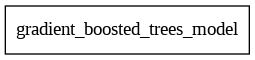

In [ ]:
# Plot the model
keras.utils.plot_model(model_gbm_1, show_shapes=True)

In [ ]:
# Model Summary provides Feature Importance information.
model_gbm_1.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (24):
	CO2_(ppm)
	H2OC_(mmol/mol)
	T_m0days
	T_m1days
	T_m2days
	T_m3days
	T_m4days
	Tdew_(degC)
	Tpot_(K)
	VPact_(mbar)
	VPdef_(mbar)
	VPmax_(mbar)
	day_cos
	day_sin
	max_wind_cos
	max_wind_sin
	p_(mbar)
	rh_(_)
	rho_(g/m**3)
	sh_(g/kg)
	time_cos
	time_sin
	wind_cos
	wind_sin

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.         "day_cos"  0.234349 ################
    2.        "time_sin"  0.224404 #############
    3.         "day_sin"  0.206207 ########
    4.        "p_(mbar)"  0.199321 #######
    5.       "CO2_(ppm)"  0.195591 ######
    6.        "time_cos" 

In [ ]:
# TDFD can plot decision trees niside it
tfdf.model_plotter.plot_model_in_colab(model_gbm_1, tree_idx=0, max_depth=6)